In [1]:
import pandas as pd
import numpy as np
import random
import copy
from collections import deque

# Create directed graph from dataset
graph = {}
with open('./datasets/facebook_dataset.txt', 'r') as f:
    for line in f:
        k, v = line.split()
        if k not in graph:
            graph[k] = []
        graph[k].append(v)

        if v not in graph:
            graph[v] = []
        graph[v].append(k)

In [4]:
# Construct Reverse Set of Graph G for estimation of influence function
def transpose_graph(graph):
    transposed_graph = {node: [] for node in graph}
    for node in graph:
        for neighbor in graph[node]:
            transposed_graph[neighbor].append(node)

    return transposed_graph

In [5]:
# Initilalize probabilities
def initialize_probabilities(graph, topics):
    probabilities = {}
    for k,v in graph.items():
        if k not in probabilities:
            probabilities[k] = {}
        for e in v:
            probabilities[k][e] = []
    for u in graph:
        for v in graph[u]:
            dv = len(graph[u])  # In-degree of v
            probability = [2*i/(topics*dv) for i in range(1, topics+1)]
            random.shuffle(probability)
            probabilities[u][v] = probability
    return probabilities

In [6]:
# Find the estimate value of influence from set of node S in estimated graph using random sampling method
def objective_function(S, estimate):
    S = [set(s) for s in S]
    sum = 0
    for j,i in enumerate(S):
        for graph in estimate[j]:
            if any(values in i for values in graph):
                sum +=1
    return sum

In [7]:
# Building hypergraph with Independent cascade process
def independent_cascade(graph, R, probabilities, topic):
    V = set(graph.keys())  # Set of nodes in G
    H = [[] for _ in range(topic)]  # Set of hyperedges in the hypergraph
    for k in range(topic):    
        for _ in range(R):
            seed_node = random.choice(list(V))  # Choose a node uniformly at random from G
            activated_nodes = set()             # Set of nodes discovered during influence spread
            activated_nodes.add(seed_node)
            newly_activated_nodes = set(seed_node)
            newly_activated_nodes.add(seed_node)
            while newly_activated_nodes:
                newly_activated_nodes_next = set()
                for node in newly_activated_nodes:
                    if node in graph:
                        for neighbor in graph[node]:
                            if neighbor not in activated_nodes:
                                if random.random() <= probabilities[node][neighbor][k]:
                                    newly_activated_nodes_next.add(neighbor)
                                    activated_nodes.add(neighbor)
                newly_activated_nodes = newly_activated_nodes_next
            H[k].append(activated_nodes)

    return H

In [8]:
def calculate_marginal_difference(S,estimate, e):
    topic = len(S)
    base = [objective_function(S,estimate)]*topic
    next = []
    for i in range(topic):
        new_set = copy.deepcopy(S)
        new_set[i].append(e)
        next.append(objective_function(new_set, estimate))
    margin = np.subtract(next,base).tolist()
    return margin

In [9]:
def submodular_maximization(C, D, B, V, estimate, topic=3):
    S = [deque() for _ in range(topic)]  # Initialize S as a list of deques
    phi = [0] * topic  # Initialize phi for each topic
    
    for i in V:
        print(f'Incoming element: {i}')
        diff = calculate_marginal_difference(S, estimate, i)
        
        margin = np.subtract(diff,phi).tolist()
        print(f'Marginal Difference: {margin}')

        index = margin.index(max(margin))
        print(f'Selected Topic: {index}')
        if margin[index] >= 0:
            gamma = margin[index]
            phi[index] += (D/B[index])*diff[index] + (((C-D)/B[index])*gamma)

            if len(S[index]) < B[index]:
                S[index].append(i)
            else:
                S[index].popleft()
                S[index].append(i)
        print(f'Phi: {phi}, Gamma: {gamma}')
        print(f'Updated Set: {S}')
    obj_value = objective_function(S,estimate)
    return S, obj_value

In [10]:
# Initialize Parameters
topic = 3
reverse_set = transpose_graph(graph)
probs = initialize_probabilities(reverse_set,topic)

In [11]:
# Initilize estimated Graph
import math
R = 100                           #int(len(reverse_set.keys())* topic**2*math.log(len(reverse_set.keys()))*math.log(topic)) # O(n*k**2*log(n)*log(k))
print(f'Theoritical Bound for Number of Simulations: {R}')
estimate = independent_cascade(reverse_set, R, probs, topic)

Theoritical Bound for Number of Simulations: 100


In [12]:
B = [5] * topic
D = B[0] * (2**(1/B[0])-1)
C = 0.5*D
V = list(reverse_set.keys())
s, obj_value = submodular_maximization(C, D, B, V, estimate, topic) 

Incoming element: 0
Marginal Difference: [89, 92, 85]
Selected Topic: 1
Phi: [0, 6.840124329863615, 0], Gamma: 92
Updated Set: [deque([]), deque(['0']), deque([])]
Incoming element: 1
Marginal Difference: [16.0, -6.840124329863615, 9.0]
Selected Topic: 0
Phi: [1.1895868399762808, 6.840124329863615, 0], Gamma: 16.0
Updated Set: [deque(['1']), deque(['0']), deque([])]
Incoming element: 2
Marginal Difference: [13.81041316002372, -6.840124329863615, 10.0]
Selected Topic: 0
Phi: [2.3932693055693415, 6.840124329863615, 0], Gamma: 13.81041316002372
Updated Set: [deque(['1', '2']), deque(['0']), deque([])]
Incoming element: 3
Marginal Difference: [1.6067306944306585, -6.840124329863615, 11.0]
Selected Topic: 2
Phi: [2.3932693055693415, 6.840124329863615, 0.817840952483693], Gamma: 11.0
Updated Set: [deque(['1', '2']), deque(['0']), deque(['3'])]
Incoming element: 4
Marginal Difference: [2.6067306944306585, -5.840124329863615, 7.182159047516307]
Selected Topic: 2
Phi: [2.3932693055693415, 6.840

In [13]:
import copy
def calculate_marginal_difference_greedy(S,estimate, items, topics):
    margin = {}
    base = objective_function(S,estimate)
    for e in items:
        for t in topics:
            new_set = copy.deepcopy(S)
            new_set[t].append(e)
            margin[(e,t)] = objective_function(new_set,estimate) - base
    max_key = max(margin, key=margin.get)
    max_value = margin[max_key]
    return max_key, max_value

In [14]:
def greedy_algorithm(nodes, estimate, B, topics=3):
    S = [[] for _ in range(topics)]  # Initialize S as a list of lists
    B_total = sum(B)                # Find total budget
    elements = list(nodes)
    for _ in range(B_total):
        indices = list(filter(lambda x: B[x] > 0, range(len(B))))
        if not indices or not elements:
            break
        (e,i), _ = calculate_marginal_difference_greedy(S,estimate,elements, indices)
        S[i].append(e)
        elements.remove(e)
        B[i] -= 1
    obj_value = objective_function(S,estimate)
    return S, obj_value

In [15]:
topic = 3
B = [1] * topic
nodes = list(reverse_set.keys())
result, obj_value = greedy_algorithm(nodes, estimate, B=B, topics=topic)
print(f'Result of Greedy Algorithm: {result}')
print(f'Result of the Objective Value: {round(obj_value,2)}')

Result of Greedy Algorithm: [['271'], ['0'], ['25']]
Result of the Objective Value: 191


In [ ]:
import matplotlib.pyplot as plt
topic = 3
results_greedy = []
results_proposed = []
num_iter = 5
std = []
nodes = list(reverse_set.keys())
budget = 10
for b in range(1,budget):
    B = [b]*topic
    D = B[0] * (2**(1/B[0])-1)
    C = 0.5*D
    _, result_greedy  = greedy_algorithm(nodes, estimate, B=B, topics=topic)
    results_greedy.append(result_greedy)
    sub_eval = []
    for i in range(num_iter):
        random.shuffle(nodes)
        B = [b]*topic
        _, result_proposed  = submodular_maximization(C=C,D=D,B=B,V=nodes,estimate=estimate,topic=topic)
        sub_eval.append(result_proposed)
    
    results_proposed.append(np.mean(sub_eval))
    std.append(np.std(sub_eval))
stats = pd.DataFrame({'B': list(range(1,budget)), 'Mean': results_proposed, 'Std': std})

Text(0, 0.5, 'Function Value')

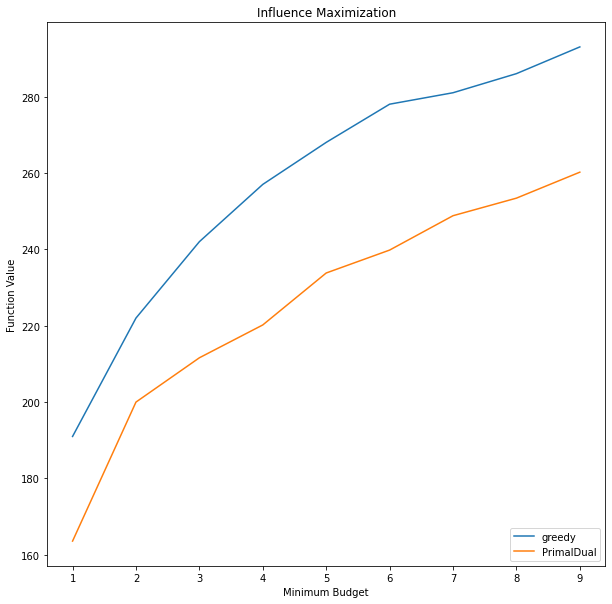

In [28]:
plt.figure(figsize=(10,10))
plt.plot(list(range(1,10)), results_greedy, label="greedy")
plt.plot(list(range(1,10)), results_proposed, label = "PrimalDual")
plt.legend(loc="lower right")
plt.title('Influence Maximization')
plt.xlabel('Minimum Budget')
plt.ylabel('Function Value')